In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats
import dynesty
import corner
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,5]

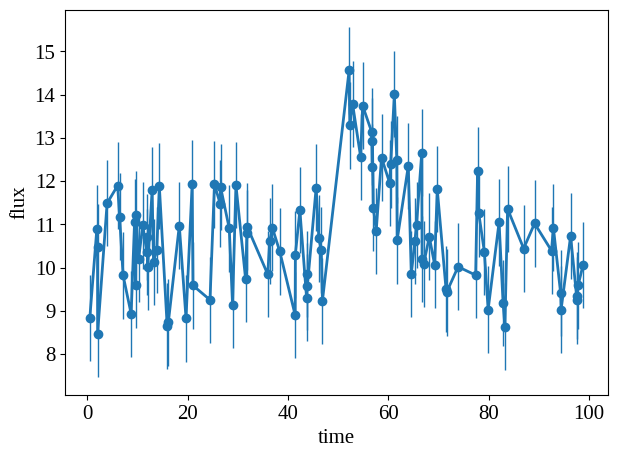

In [2]:
data=np.load('transient.npy')

time=data[:,0]
flux=data[:,1]
err=data[:,2]

plt.scatter(time, flux)
plt.errorbar(time, flux, err, lw=2, elinewidth=1)
plt.xlabel("time")
plt.ylabel("flux")
plt.show()

In [3]:
ndim=4

def burst(par, time):
    b, A, t_0, alpha = par
    y=np.empty(len(time))
    for i in range(len(time)):
        if time[i]<t_0:
            y[i]=b
        else:
            y[i]=b + A * np.exp(-alpha*(time[i]-t_0)) 
    return y

In [4]:
def prior_burst(u):         
    b = u[0]*50           
    A = u[1]*50                # A, b from uniform(0,50)    
    t_0 = u[2]*100              # to from uniform(0,100)    
    alpha = scipy.stats.loguniform.ppf(u[3], np.exp(-5), np.exp(5))     # ln(alpha) from uniform(-5, 5)
    
    par = np.array([b, A, t_0, alpha])   
    return(par)

def loglike_burst(par, time, flux, err):
    b, A, t_0, alpha = par
    model_burst = burst(par, time)
    return - 0.5 * np.sum((flux-model_burst)**2/(err**2))

In [5]:
sampler_burst = dynesty.NestedSampler(loglike_burst, prior_burst, ndim, logl_args=[time, flux, err])
sampler_burst.run_nested()
result_burst = sampler_burst.results

7588it [01:09, 109.31it/s, +500 | bound: 131 | nc: 1 | ncall: 124323 | eff(%):  6.532 | loglstar:   -inf < -48.789 <    inf | logz: -63.176 +/-  0.167 | dlogz:  0.001 >  0.509]


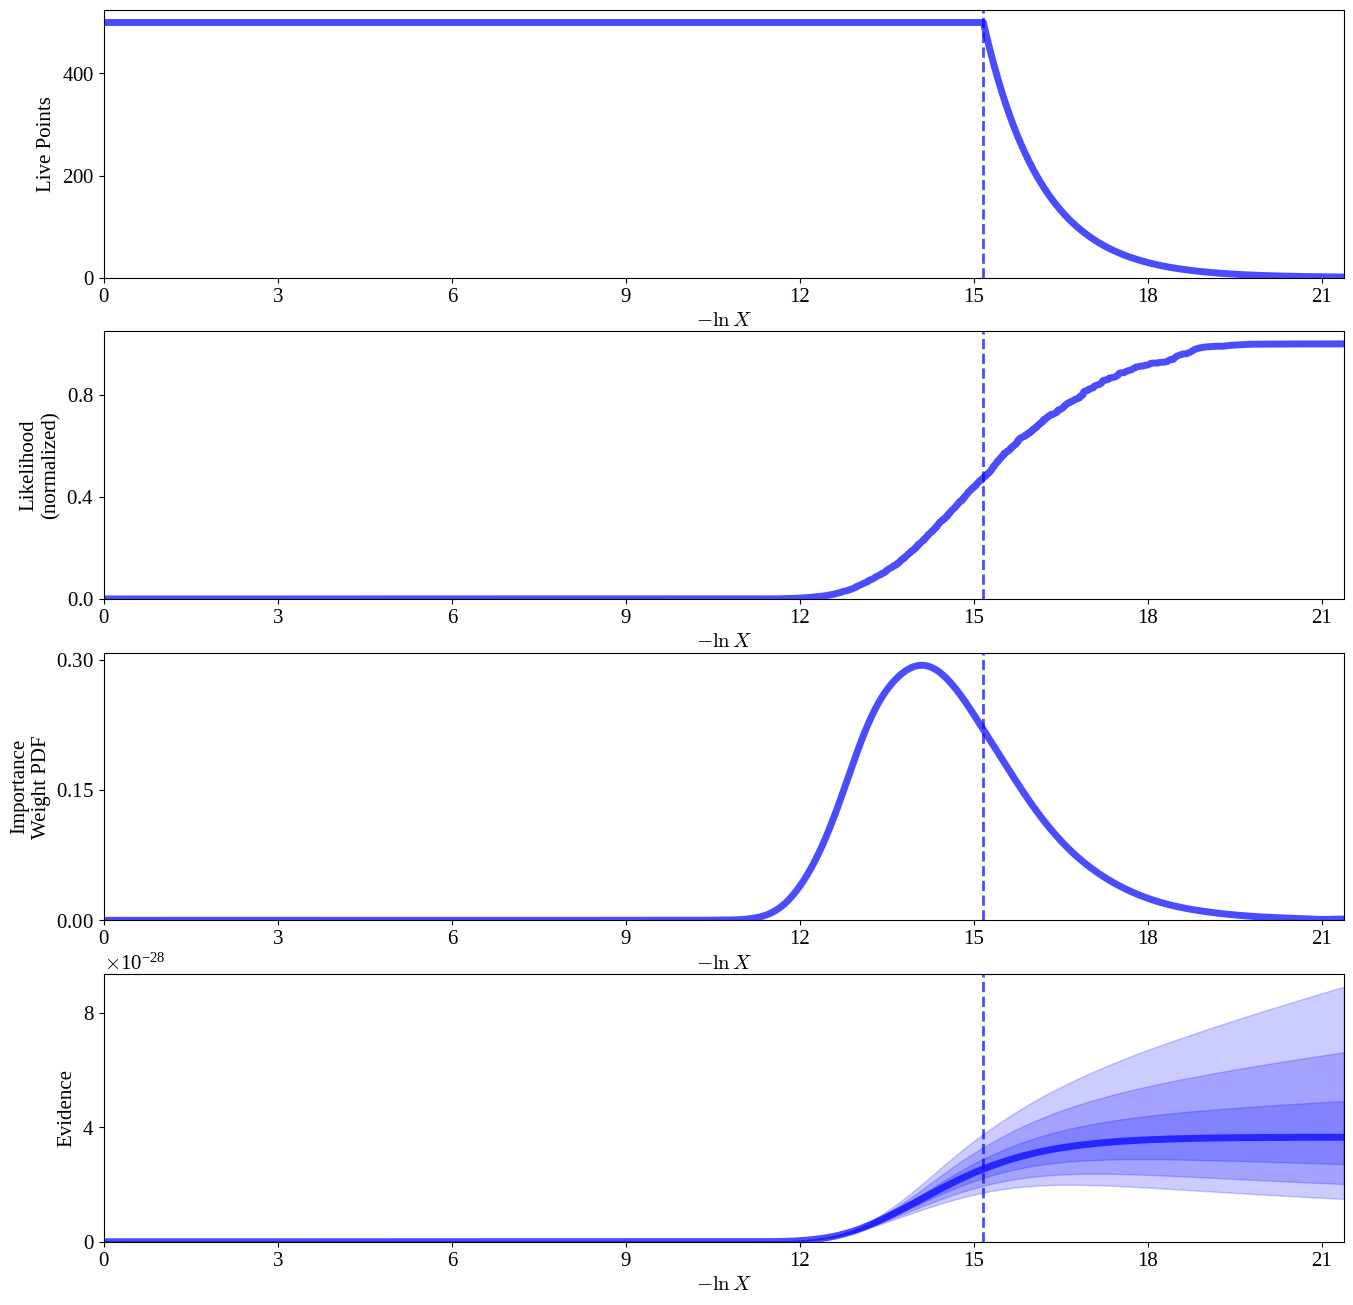

In [6]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(result_burst)

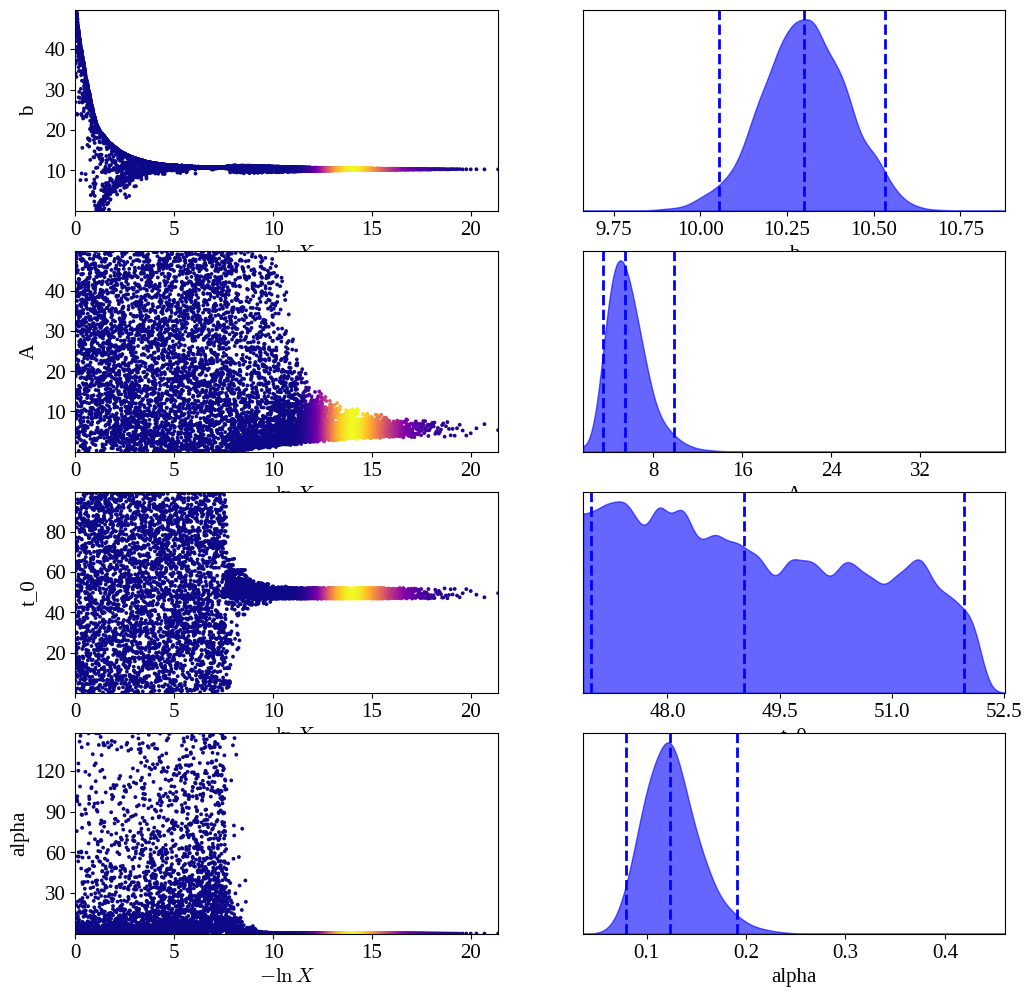

In [7]:
labels_burst = ["b","A","t_0","alpha"]

tfig, taxes = dyplot.traceplot(result_burst, labels=labels_burst)

In [8]:
samples_burst = result_burst.samples
weights_burst = np.exp(result_burst.logwt - result_burst.logz[-1])

samples_eq_burst = dyfunc.resample_equal(samples_burst, weights_burst)

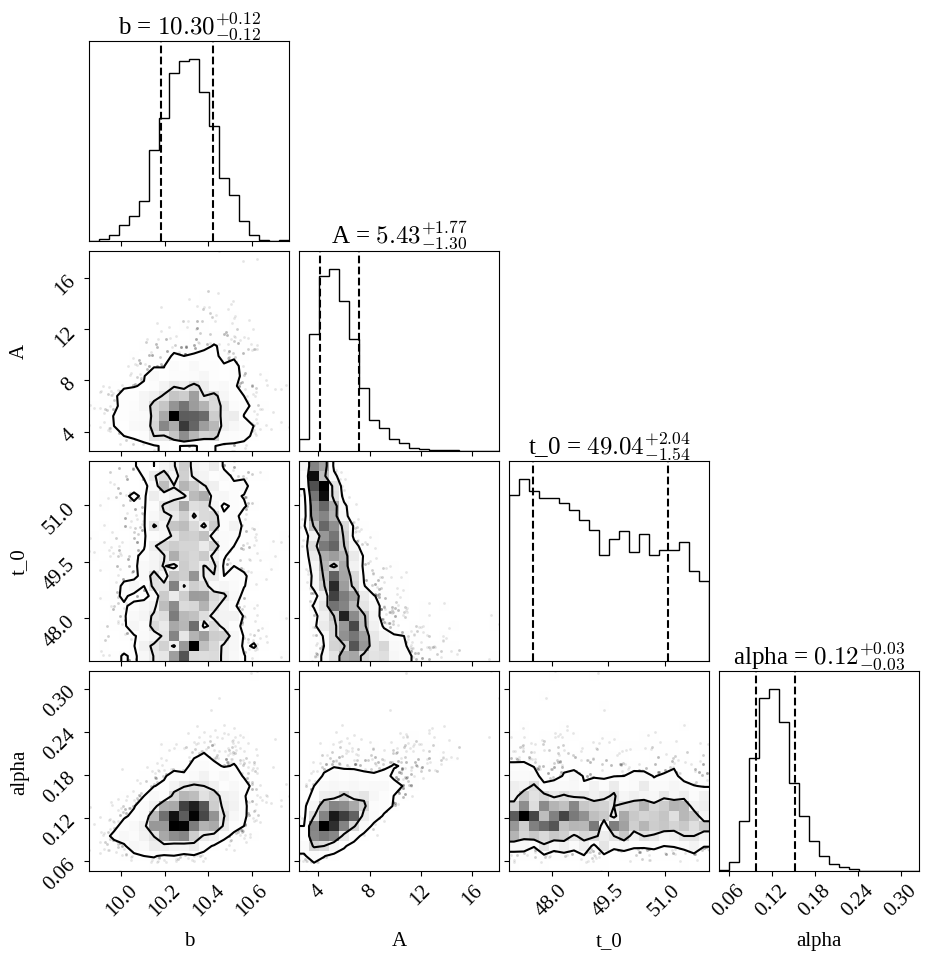

In [9]:
fig = corner.corner(samples_eq_burst, labels=labels_burst, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [10]:
quantiles_burst = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_burst)
             for samps in samples_burst.T]
for q,l in zip(quantiles_burst,labels_burst):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

b = 10.3 + 0.21 - 0.2
A = 5.44 + 3.52 - 1.81
t_0 = 49.03 + 2.73 - 1.95
alpha = 0.12 + 0.05 - 0.04


In [11]:
# Gaussian model

def gauss_model(par, time):
    b, A, t_0, sigma = par 
    return b+A*np.exp(-(((time-t_0)/sigma)**2 ) / 2)

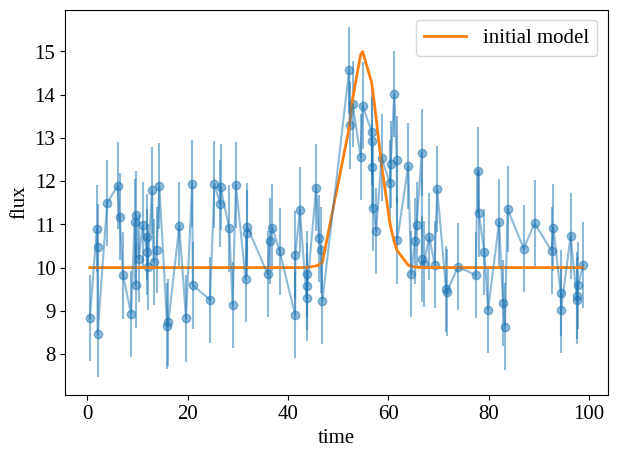

In [12]:
#fit the data with the gaussian model to find reasonable priors

b, A, t_0, sigma = 10, 5, 55, 3
par = [b, A, t_0, sigma]

flux_model_gauss = gauss_model(par, time)

plt.scatter(time, flux, alpha=0.5)
plt.errorbar(time, flux, err, alpha=0.5)
plt.plot(time, flux_model_gauss, label='initial model', lw=2)
plt.legend()
plt.ylabel('flux')
plt.xlabel('time')
plt.show()

In [13]:
def prior_gauss(u):         
    b = u[0]*50           
    A = u[1]*50                # A, b from uniform(0,50)    
    t_0 = u[2]*100              # to from uniform(0,100)    
    sigma = scipy.stats.loguniform.ppf(u[3], np.exp(-2), np.exp(2))     # ln(sigma) from uniform(-2, 2)
    
    par = np.array([b, A, t_0, sigma])   
    return(par)

def loglike_gauss(par, time, flux, err):
    b, A, t_0, sigma = par
    model_gauss = gauss_model(par, time)
    return - 0.5 * np.sum((flux-model_gauss)**2/(err**2))

In [ ]:
sampler_gauss = dynesty.NestedSampler(loglike_gauss, prior_gauss, ndim, logl_args=[time, flux, err])
sampler_gauss.run_nested()
result_gauss = sampler_gauss.results

5920it [00:42, 483.84it/s, bound: 96 | nc: 2 | ncall: 94331 | eff(%):  6.276 | loglstar:   -inf < -62.144 <    inf | logz: -75.437 +/-  0.156 | dlogz: 10.733 >  0.509]      

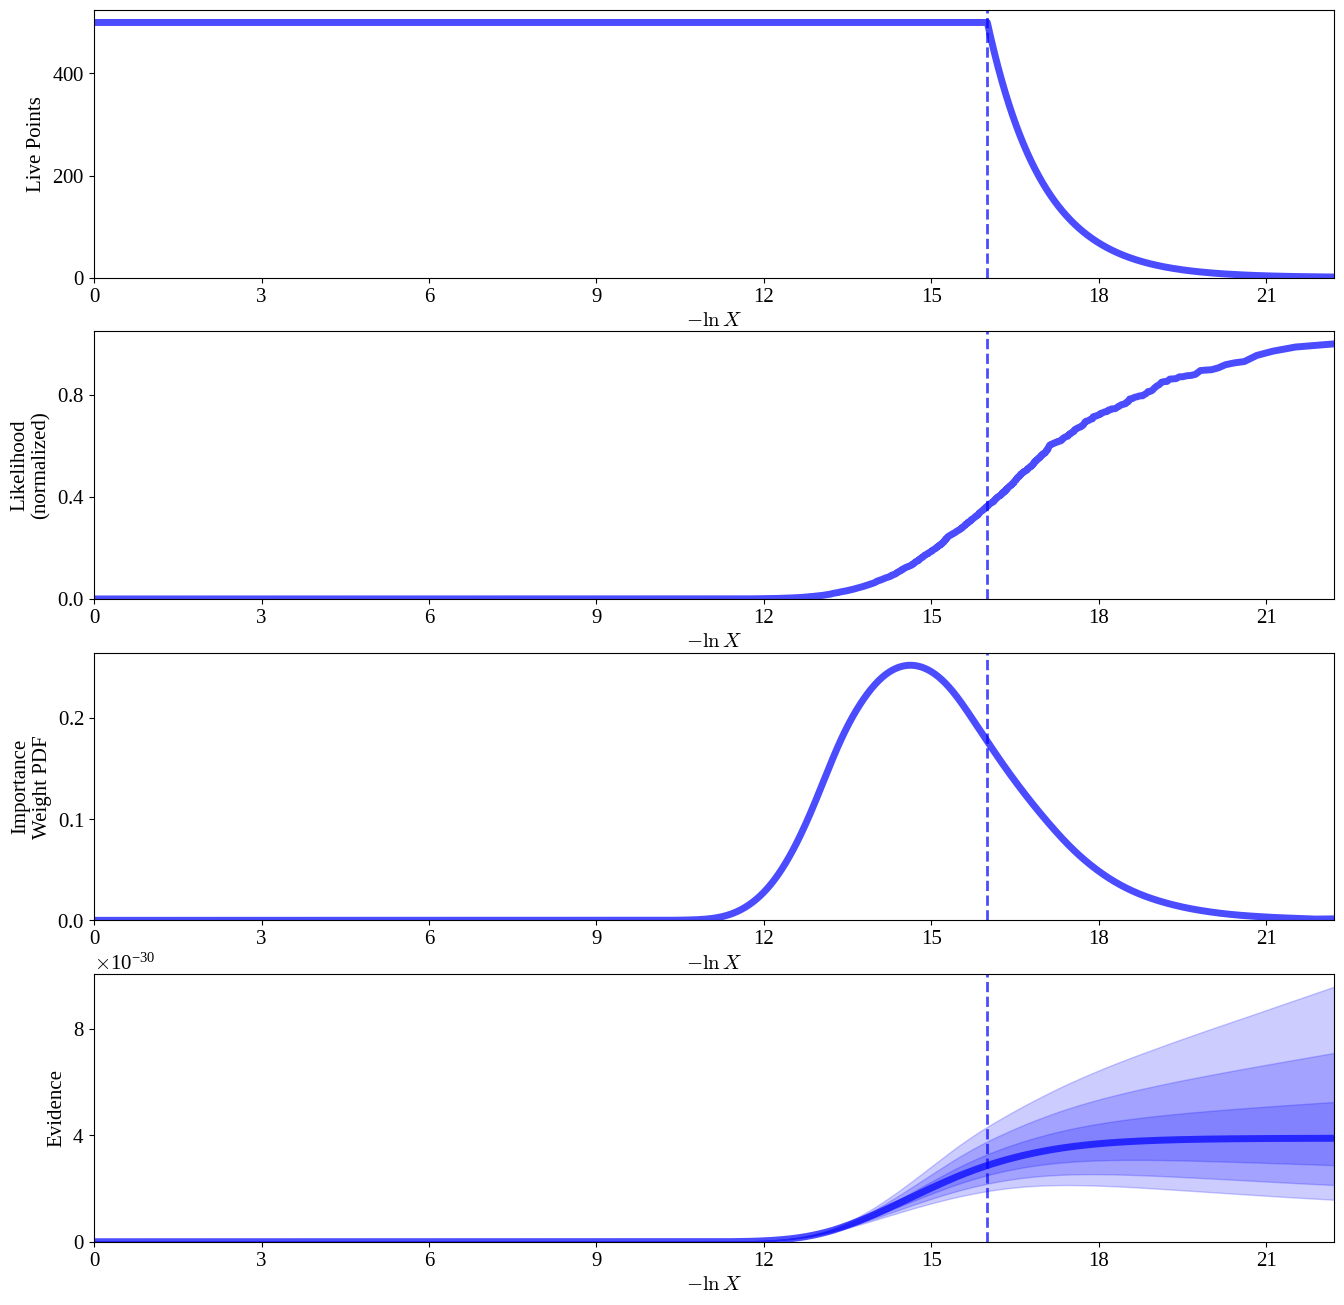

In [60]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(result_gauss)

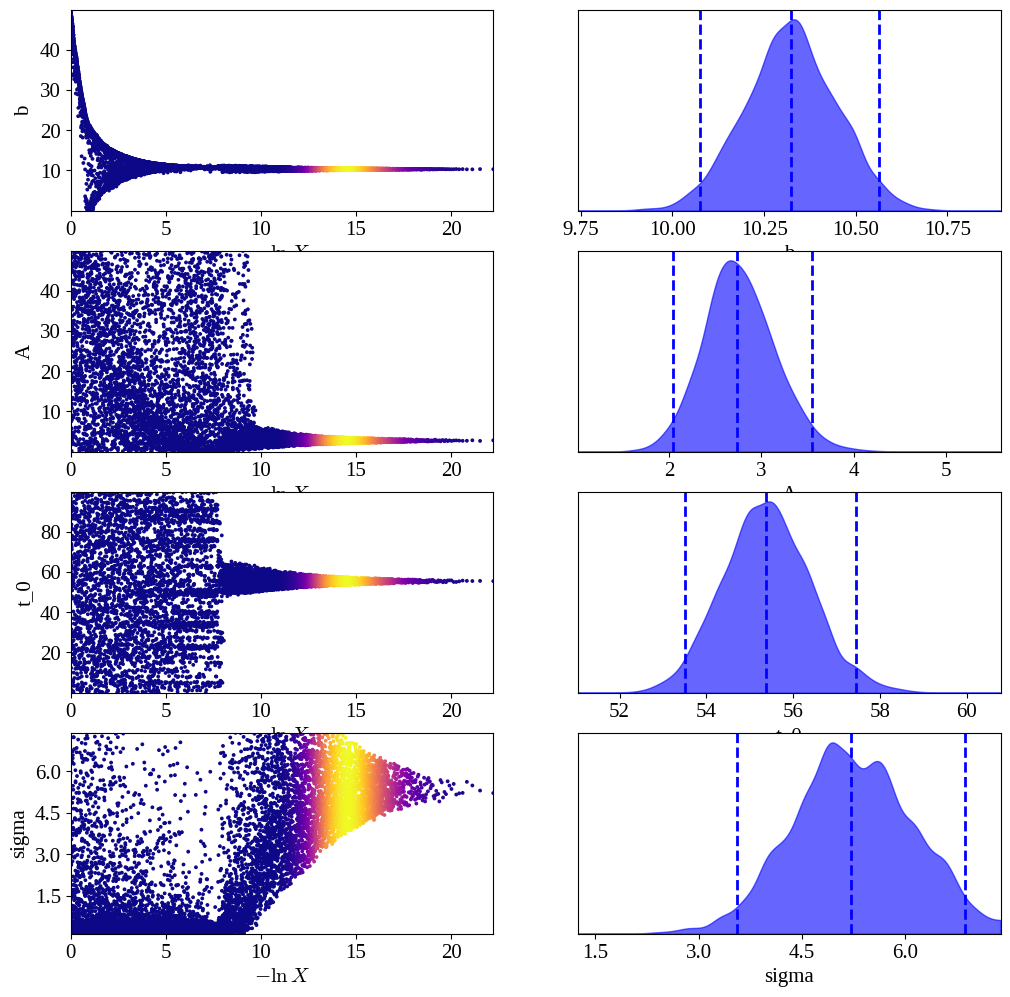

In [62]:
labels_gauss = ["b","A","t_0","sigma"]

tfig, taxes = dyplot.traceplot(result_gauss, labels=labels_gauss)

In [65]:
samples_gauss = result_gauss.samples
weights_gauss = np.exp(result_gauss.logwt - result_gauss.logz[-1])

samples_eq_gauss = dyfunc.resample_equal(samples_gauss, weights_gauss)

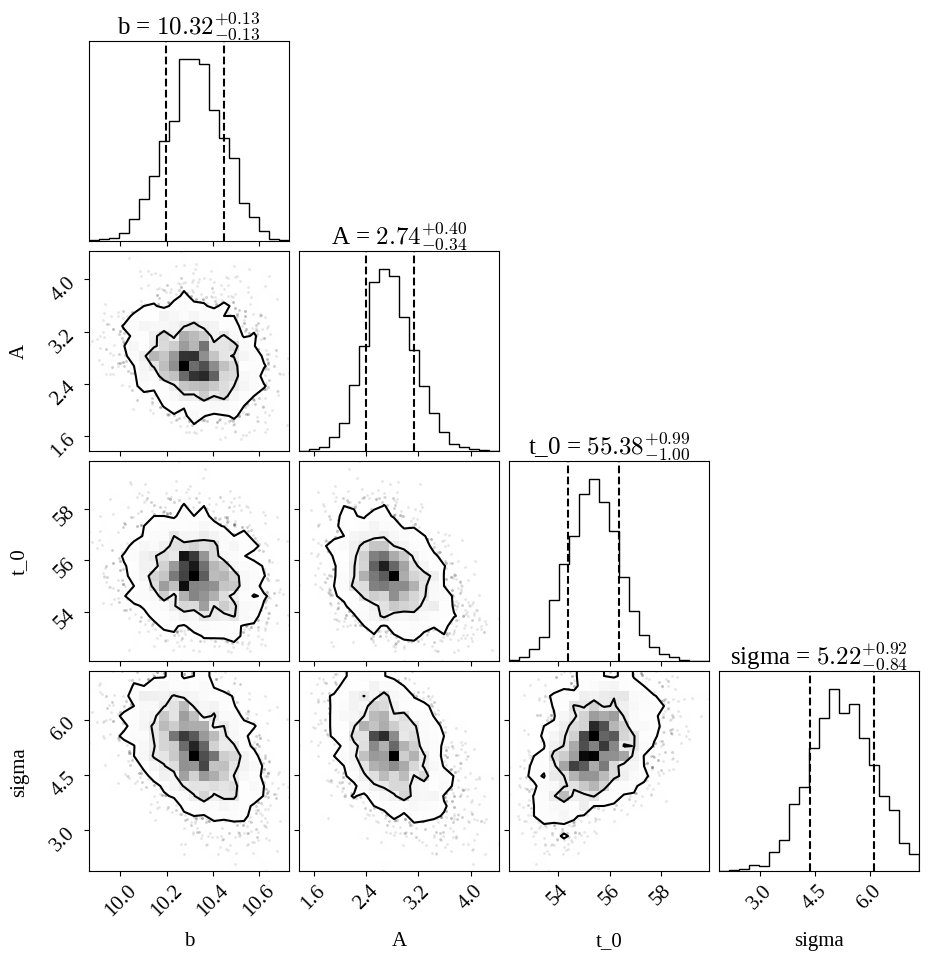

In [66]:
fig = corner.corner(samples_eq_gauss, labels=labels_gauss, levels=[0.68,0.95], quantiles=[0.16, 0.84], show_titles=True)

In [67]:
quantiles_gauss = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_gauss)
             for samps in samples_gauss.T]
for q,l in zip(quantiles_gauss,labels_gauss):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

b = 10.32 + 0.2 - 0.21
A = 2.74 + 0.69 - 0.57
t_0 = 55.38 + 1.67 - 1.61
sigma = 5.21 + 1.44 - 1.36


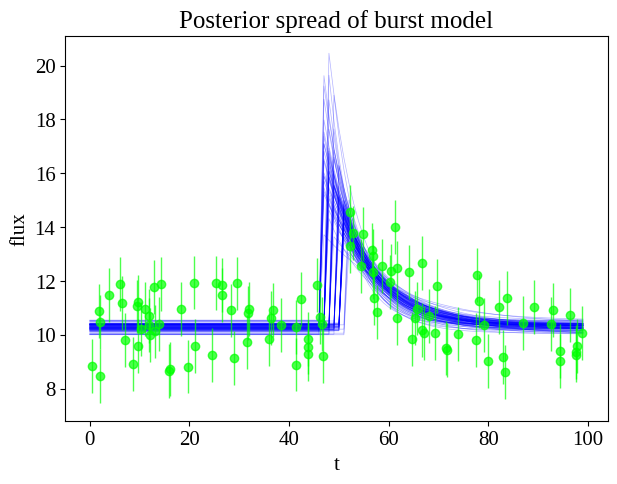

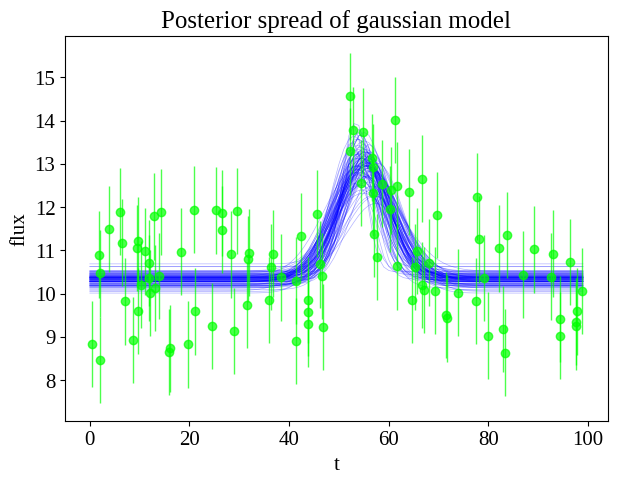

In [82]:
# model comparison

burst100 = samples_eq_burst[np.random.choice(range(len(samples_eq_burst)), 100)]
gauss100 = samples_eq_gauss[np.random.choice(range(len(samples_eq_gauss)), 100)]
t = np.linspace(0,100,100)

flux_burst_model = np.array([burst(par, t) for par in burst100])

for i in range(len(flux_burst_model)):
    plt.plot(flux_burst_model[i], alpha=0.3, color='blue', lw=0.5)
    plt.title('Posterior spread of burst model')
    plt.xlabel('t')
    plt.ylabel('flux')

plt.errorbar(time, flux, err, lw=2, elinewidth=1, fmt='o', color='lime', alpha=0.7)
plt.show()

flux_gauss_model = np.array([gauss_model(par, t) for par in gauss100])

for i in range(len(flux_gauss_model)):
    plt.plot(flux_gauss_model[i], alpha=0.3, color='blue', lw=0.5)
    plt.title('Posterior spread of gaussian model')
    plt.xlabel('t')
    plt.ylabel('flux')

plt.errorbar(time, flux, err, lw=2, elinewidth=1, fmt='o', color='lime', alpha=0.7)
plt.show()

In [84]:
evidence_burst = np.exp(result_burst.logz[-1])
evidence_gauss = np.exp(result_gauss.logz[-1])

Bayes_factor = evidence_burst/evidence_gauss

print(Bayes_factor)

# the burst model fits better the data

70.5168329222584
